# Using machine learning to predict future stock prices using technical and fundamental data

### Installation of libraries (consider conda install for working env first)


In [333]:
# !pip install altair
# !pip install pandas_ta
# !pip install requests_html
# !pip install requests
# pip install scikit-plot
# !pip install --user tensorflow
# pip install --upgrade pip
# !pip install yahoo_fin --upgrade
# !pip install yfinance --upgrade --no-cache-dir
# !pip install --user pycaret
# pip install scikit-learn==0.23.2
# pip install benzinga
# !pip install --user yahooquery
# !pip install pycaret
# !pip install mplfinance
# !pip install requests_cache
# !pip install certifi
# !pip install polygon-api-client~=1.0.0b

### Importing relevant libraries

In [8]:
from polygon import RESTClient
import getpass
from datetime import date
 
# Returns the current local date
today = date.today()
dateOfMonth = today.day
monthNumber = today.month
yearNumber = today.year

In [295]:
import ftplib
import io
import pandas as pd
import pandas_ta as ta
import requests
import requests_html
import numpy as np

# from pycaret.classification import *
# from pycaret.regression import *

import yfinance as yf
from yahoo_fin.stock_info import get_data, get_top_crypto, get_analysts_info
import yahoo_fin.stock_info as si
import yahoo_fin.options as ops
from yahoo_fin.stock_info import *

# Dow: tickers_dow()
# Nasdaq: tickers_nasdaq()
# S&P500: tickers_sp500()
# Others: tickers_other()

# import tensorflow as tf
import altair as alt

# from benzinga import financial_data
# from benzinga import news_data

import mplfinance as mpf

import requests_cache

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

import metricFxns
from metricFxns import *
import vizFxns
from vizFxns import *

from sklearn import metrics
from sklearn import datasets

from yahooquery import Ticker

import ssl
import certifi
import urllib


### Yahoo_fin has two modules - stock_info and options.
---------
#### Stock_info has the following methods:

#### get_analysts_info(), get_balance_sheet(), get_cash_flow(), get_data(), get_day_gainers(), get_day_losers(), get_day_most_active(), get_holders(), get_income_statement(), get_live_price(), get_quote_table(), get_top_crypto(), get_stats(), get_stats_valuation(), tickers_dow(), tickers_nasdaq(), tickers_other(), tickers_sp500()
---------
#### And options has:

#### get_calls(), get_expiration_dates(), get_options_chain(), get_puts()
---------

#### And there are the methods you can’t use without requests_html are:

#### stock_info module, get_day_gainers(), get_day_most_active(), get_day_losers(), get_top_crypto(), get_expiration_dates()
---------

### Pulling data

In [43]:
apiKey = getpass.getpass()
client = RESTClient(apiKey)
from polygon.rest import models

In [10]:
from yahoo_fin import stock_info as si

otherTickers = si.tickers_other(include_company_data = True)
nasdaqTickers = si.tickers_nasdaq(include_company_data = True)
allStocks = pd.concat([otherTickers,nasdaqTickers])
stockMarketTickers = list(allStocks['ACT Symbol'].unique())
nasdaqTicks = list(nasdaqTickers['Symbol'].unique())

In [11]:
# ticker: case insensitive ticker of the desired stock/bond
# start_date: date you want the data to start from (mm/dd/yyyy)
# end_date: date you want the data to end (mm/dd/yyyy)
# index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
# interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.
# get_data(ticker, start_date = None, end_date = None, index_as_date = True, interval = “1d”)


In [12]:
# session = requests_cache.CachedSession("yfinance.cache")
# session.headers["User-Agent"] = "prices-notebook/1.0"

# Indices
# dji = yf.Ticker("^DJI", session=session)         # DJIA
# gspc = yf.Ticker("^GSPC", session=session)       # S&P 500
# ixic = yf.Ticker("^IXIC", session=session)       # NASDAQ Composite

# Cryptocurrency
# btc_usd = yf.Ticker("BTC-USD", session=session)  # Bitcoin/USD

In [16]:
currentDate = str(monthNumber) + "/" + str(dateOfMonth) + "/" + str(yearNumber)
yearPrior = str(monthNumber) + "/" + str(dateOfMonth+1) + "/" + str(yearNumber-1)
yearPrior

'6/15/2022'

In [311]:
timeseriesDf = pd.DataFrame()
sector_etfs = ['XLE','XLV','XLU','XLI','GDX','XLK','XLY','XLB','XOP','XHB','XME','XTL']
current_portfolio = ['A','ADSK','ALB','AMD','AMGN','AMT','AMZN','APD','AZO','BFH','BKNG','BWA','CMCSA','DG','DIS','DOV','DPZ', #'BRK/B',
                     'FI','GOOG','JNJ','KO','NXPI','PG','PRMW','PXD','SBUX','SFM','UL','V','WEC','WMT','ZTO','ZTS','SPXU','SQQQ',
                     'INTC','WPP','PYPL','SLB','CPRI']
for ticker in current_portfolio: #sector_etfs
    try:
        timeseriesDf = pd.concat([timeseriesDf,get_data(ticker,start_date=yearPrior ,  end_date=currentDate, index_as_date = True, interval="1mo")])
    except:
        pass


timeseriesDf = timeseriesDf.reset_index()
timeseriesDf = timeseriesDf.rename(columns={'index':'date'})
timeseriesDf.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2022-07-01,118.79000092,134.50000000,113.01999664,134.10000610,133.21560669,27261300,A
1,2022-08-01,133.50999451,149.00000000,127.16000366,128.25000000,127.62985229,32066400,A
2,2022-09-01,127.62999725,140.00000000,120.59999847,121.55000305,120.96224976,31680800,A
3,2022-10-01,122.73000336,139.30999756,121.68000031,138.35000610,137.68101501,27011100,A
4,2022-11-01,139.50000000,157.44000244,130.66000366,154.97999573,154.49752808,30737200,A


In [312]:
historyDfs = []
for ticker in current_portfolio: #['XLV'] #sector_etfs #stockMarketTickers
    try:
        yahooTickerData = yf.Ticker(ticker, session=session)
        yahooHistory = yahooTickerData.history(period="5y", auto_adjust=False, back_adjust=False) #"max"
        yahooHistory['Ticker']=ticker
        historyDfs.append(yahooHistory)
    except:
        print(ticker)
        pass

historyDfFull = pd.concat(historyDfs)
historyDfFull.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Ticker,Capital Gains
Date,,,,,,,,,,
2018-06-18 00:00:00-04:00,65.48000336,65.54000092,64.52999878,64.97000122,62.60025406,2563100,0.00000000,0.00000000,A,NaN
2018-06-19 00:00:00-04:00,64.22000122,64.44999695,63.20000076,63.52000046,61.20314026,4621400,0.00000000,0.00000000,A,NaN
2018-06-20 00:00:00-04:00,63.54000092,63.56999969,62.63000107,62.79000092,60.49976730,4942100,0.00000000,0.00000000,A,NaN
2018-06-21 00:00:00-04:00,62.81000137,63.22000122,62.27000046,63.04000092,60.74065399,4319400,0.00000000,0.00000000,A,NaN
2018-06-22 00:00:00-04:00,63.58000183,63.68999863,62.72999954,62.79000092,60.49976730,2893800,0.00000000,0.00000000,A,NaN


In [313]:
def add_rsi(df, periods=14):
    close_diff = df["Close"].diff()
    up = close_diff.clip(lower=0)
    down = -1 * close_diff.clip(upper=0)
    ma_up = up.ewm(
        com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(
        com=periods-1, adjust=True, min_periods=periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))
    df["RSI"] = rsi

rsiDfs = []
for ticker in current_portfolio:
    histDf = historyDfFull[historyDfFull['Ticker']==ticker]
    add_rsi(histDf)
    add_macd(histDf)
    rsiDfs.append(histDf)
rsiDfFull = pd.concat(rsiDfs)
# rsiDfFull[(rsiDfFull.index==currentDate)&(rsiDfFull.Open>20)&(rsiDfFull.RSI<65)].sort_values(by='RSI')

C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\FinancialPredictions\FinancialPredictions\metricFxns.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MACD"] = macd
c:\FinancialPredictions\FinancialPredictions\metricFxns.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

## Pulling in financial data for screening

In [291]:
infoDfs = []

for stock in ['NVDA']:#,'AMD','INTC','META','AAPL','AMZN','GOOGL','MSFT','TSLA','KO']:

    ticker = yf.Ticker(stock.lower())

    # # Get quarterly earnings for the last 5 years
    # quarterly_earnings = ticker.quarterly_earnings

    # # Get quarterly cash flow for the last 5 years
    # quarterly_cashflow = ticker.quarterly_cashflow

    # # Filter the data to keep only the last 20 quarters (5 years)
    # quarterly_earnings = quarterly_earnings.tail(20)
    # quarterly_cashflow = quarterly_cashflow.tail(20)

    # print(quarterly_earnings)
    # print(quarterly_cashflow)

    infoDf = pd.DataFrame.from_dict(ticker.info, orient='index').T
    infoDfs.append(infoDf)

# infoDf = pd.DataFrame.from_dict(yf.Ticker("aapl").info, orient='index').T
infoDf = pd.concat(infoDfs)
infoDf = infoDf[[ 'symbol',
 'longName',
 'industry',
 'sector',
 'fullTimeEmployees',
 'auditRisk',
 'boardRisk',
 'compensationRisk',
 'shareHolderRightsRisk',
 'overallRisk',
 'governanceEpochDate',
 'compensationAsOfEpochDate',
 'maxAge',
 'priceHint',
 'previousClose',
 'open',
 'dayLow',
 'dayHigh',
 'regularMarketPreviousClose',
 'regularMarketOpen',
 'regularMarketDayLow',
 'regularMarketDayHigh',
 'dividendRate',
 'dividendYield',
 'exDividendDate',
 'payoutRatio',
 'fiveYearAvgDividendYield',
 'beta',
 'trailingPE',
 'forwardPE',
 'volume',
 'regularMarketVolume',
 'averageVolume',
 'averageVolume10days',
 'averageDailyVolume10Day',
 'bid',
 'ask',
 'bidSize',
 'askSize',
 'marketCap',
 'fiftyTwoWeekLow',
 'fiftyTwoWeekHigh',
 'priceToSalesTrailing12Months',
 'fiftyDayAverage',
 'twoHundredDayAverage',
 'trailingAnnualDividendRate',
 'trailingAnnualDividendYield',
 'currency',
 'enterpriseValue',
 'profitMargins',
 'floatShares',
 'sharesOutstanding',
 'sharesShort',
 'sharesShortPriorMonth',
 'sharesShortPreviousMonthDate',
 'dateShortInterest',
 'sharesPercentSharesOut',
 'heldPercentInsiders',
 'heldPercentInstitutions',
 'shortRatio',
 'shortPercentOfFloat',
 'impliedSharesOutstanding',
 'bookValue',
 'priceToBook',
 'lastFiscalYearEnd',
 'nextFiscalYearEnd',
 'mostRecentQuarter',
 'earningsQuarterlyGrowth',
 'netIncomeToCommon',
 'trailingEps',
 'forwardEps',
 'pegRatio',
 'lastSplitFactor',
 'lastSplitDate',
 'enterpriseToRevenue',
 'enterpriseToEbitda',
 '52WeekChange',
 'SandP52WeekChange',
 'lastDividendValue',
 'lastDividendDate',
 'exchange',
 'quoteType',
 'gmtOffSetMilliseconds',
 'currentPrice',
 'targetHighPrice',
 'targetLowPrice',
 'targetMeanPrice',
 'targetMedianPrice',
 'recommendationMean',
 'recommendationKey',
 'numberOfAnalystOpinions',
 'totalCash',
 'totalCashPerShare',
 'ebitda',
 'totalDebt',
 'quickRatio',
 'currentRatio',
 'totalRevenue',
 'debtToEquity',
 'revenuePerShare',
 'returnOnAssets',
 'returnOnEquity',
 'grossProfits',
 'freeCashflow',
 'operatingCashflow',
 'earningsGrowth',
 'revenueGrowth',
 'grossMargins',
 'ebitdaMargins',
 'operatingMargins',
 'financialCurrency',
 'trailingPegRatio']]
infoDf.head()


,symbol,longName,industry,sector,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,...,grossProfits,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio
0,NVDA,NVIDIA Corporation,Semiconductors,Technology,26196,5,9,1,8,7,...,15356000000,5470499840,6821000192,0.28100000,-0.13200000,0.56314000,0.23534000,0.17374000,USD,2.42580000


## Forecasting

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

In [298]:
endWeekDate = str(yearNumber)+"-"+str(monthNumber)+"-"+str(dateOfMonth)
startWeekDate = str(yearNumber-5)+"-"+str(monthNumber)+"-"+str(dateOfMonth+1)

In [299]:
rsiDfFull = rsiDfFull.dropna(subset=['RSI'])

In [300]:
rsiDfFull[rsiDfFull['Ticker']==ticker].index

DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)

In [314]:
# Set the date as index 
# Select the proper time period for weekly aggreagation

resampleDfs = []
for ticker in current_portfolio:
    resampleDf = rsiDfFull[rsiDfFull['Ticker']==ticker]

    # # Specify the desired frequency and generate a date range
    # desired_freq = 'B'  # Business day frequency (excluding weekends)
    # date_range = pd.date_range(start=resampleDf.index.min(), end=resampleDf.index.max(), freq=desired_freq)

    # # Reindex the DataFrame using the generated date range
    # resampleDf = resampleDf.reindex(date_range)

    # resampleDf.index.freq = pd.infer_freq(resampleDf.index)
    # print(resampleDf.index.freq)
    # resampleDf = resampleDf[startWeekDate:endWeekDate].resample('W').sum()
    
    resampleDfWeekly = resampleDf[startWeekDate:endWeekDate].resample('W').mean()
    resampleDfWeekly.index.freq = pd.infer_freq(resampleDfWeekly.index)
    resampleDfWeekly['Ticker'] = ticker
    resampleDfs.append(resampleDfWeekly)

resampleRsiDfFull = pd.concat(resampleDfs)
resampleRsiDfFull.head()
print(resampleRsiDfFull[resampleRsiDfFull['Ticker']==ticker].index.freq)


None


<Week: weekday=6>


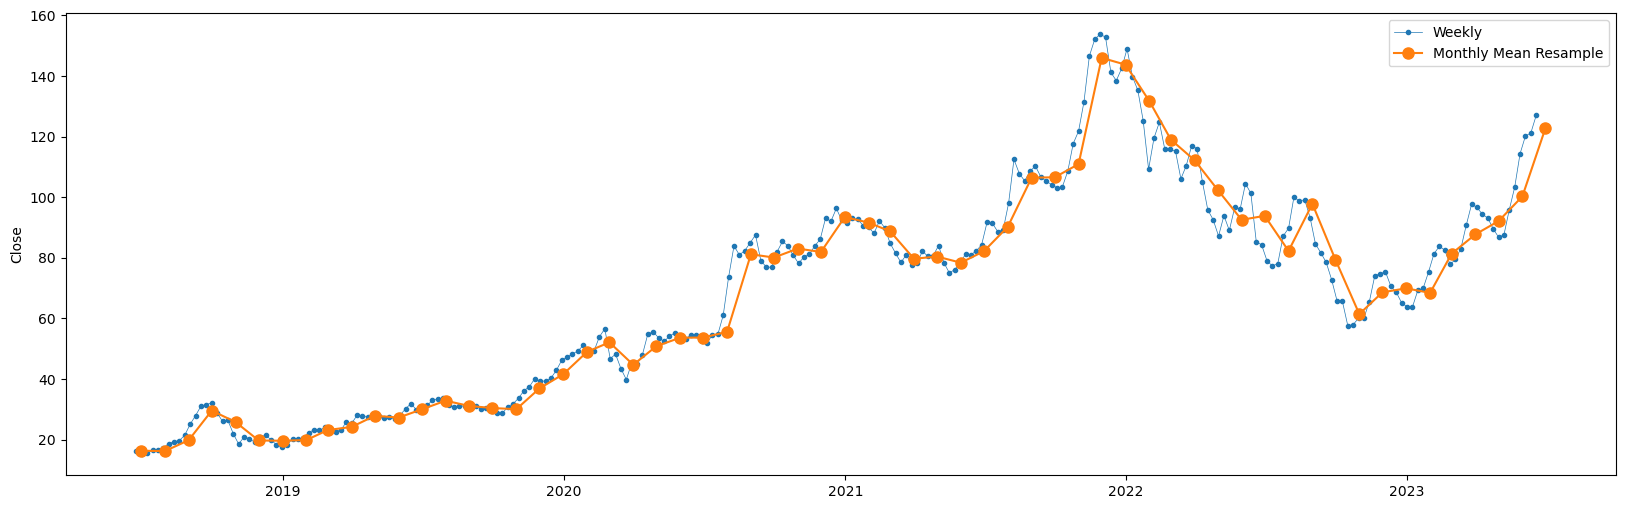

In [317]:
import warnings
import matplotlib.pyplot as plt
y = resampleRsiDfFull[resampleRsiDfFull['Ticker']=='AMD']['Close']
y.index.freq = pd.infer_freq(resampleDfWeekly.index)
print(y.index.freq)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Close')
ax.legend()

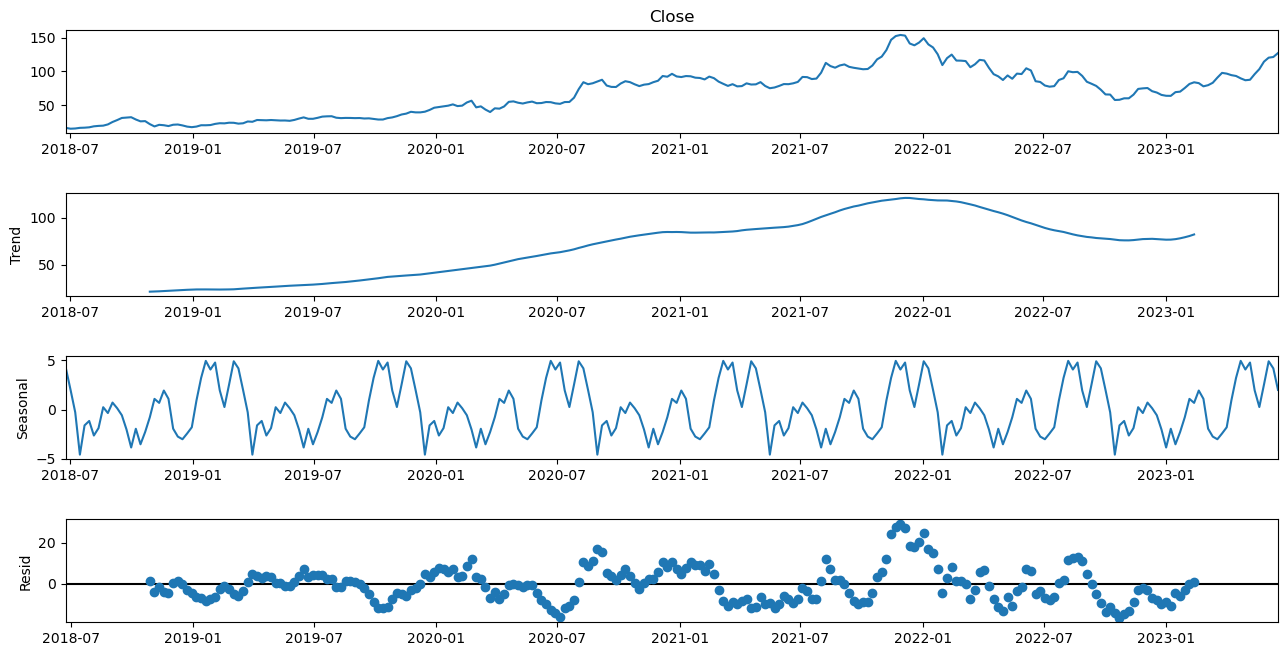

In [318]:
import statsmodels.api as sm
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=int((len(y)/7)))
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose (y)

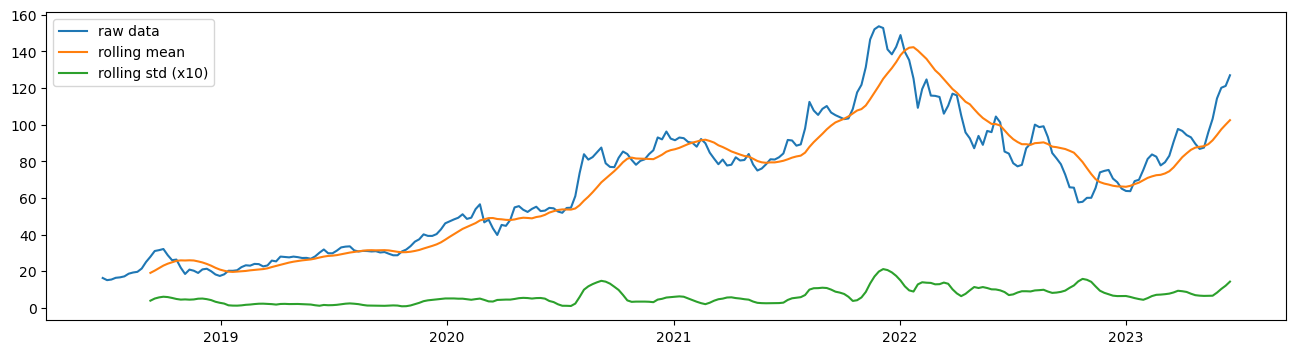

In [319]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [320]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.284
P-value = 0.636
Critical values :
	1%: -3.4558530692911504 - The data is not stationary with 99% confidence
	5%: -2.872764881778665 - The data is not stationary with 95% confidence
	10%: -2.572751643088207 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -5.429
P-value = 0.000
Critical values :
	1%: -3.4569962781990573 - The data is  stationary with 99% confidence
	5%: -2.8732659015936024 - The data is  stationary with 95% confidence
	10%: -2.573018897632674 - The data is  stationary with 90% confidence


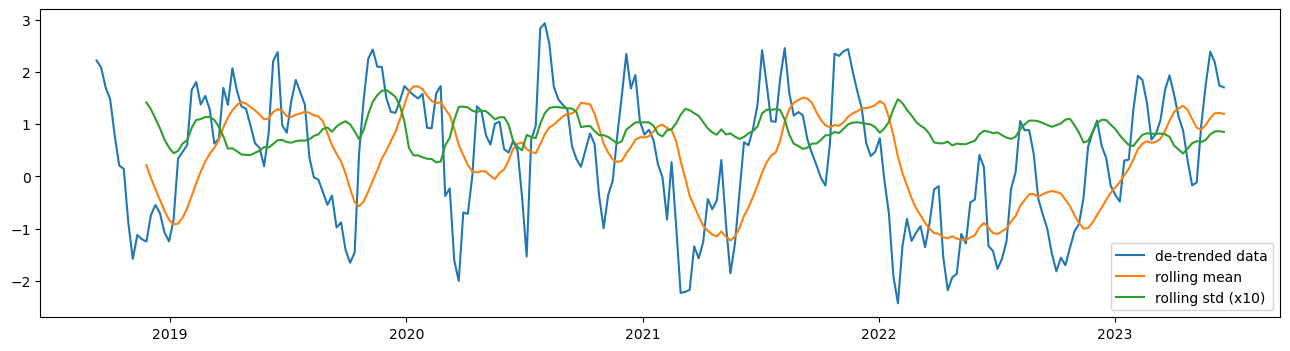

In [321]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.942
P-value = 0.002
Critical values :
	1%: -3.459884913337196 - The data is  stationary with 99% confidence
	5%: -2.8745310704320794 - The data is  stationary with 95% confidence
	10%: -2.573693840082908 - The data is  stationary with 90% confidence


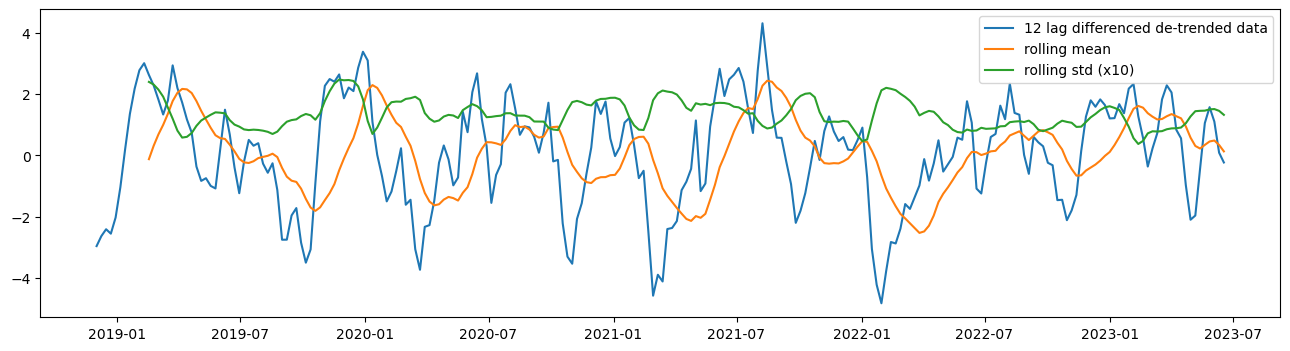

In [322]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [323]:
endTrainingWeekDate = str(yearNumber)+"-"+str(monthNumber-4)+"-"+str(dateOfMonth-7)
startTestWeekDate = str(yearNumber)+"-"+str(monthNumber-4)+"-"+str(dateOfMonth) #pd.to_datetime(startTestWeekDate).tz_localize('America/New_York')
startTestWeekNearestWeek = str(yearNumber)+"-"+str(monthNumber-4)+"-"+str(dateOfMonth-2) 
print(endTrainingWeekDate)
print(startTestWeekNearestWeek)
print(startTestWeekDate)

2023-2-7
2023-2-12
2023-2-14


In [324]:
print(y.index.freq)

y_to_train = y[:endTrainingWeekDate] # dataset to train
y_to_val = y[startTestWeekDate:] # last X months for test  
predict_date = len(y) - len(y[:startTestWeekDate]) # the number of data points for the test set

261
243


Additive: xt = Trend + Seasonal + Random
Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.
Multiplicative: xt = Trend * Seasonal * Random
The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.

Once you figure out which type of seasonality you’re dealing with in your data, you can identify the frequency of seasonality or m. For data with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with 2 years of data, and we aggregated it by week, so each data point is one week, so m = 52.

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 20.91


c:\FinancialPredictions\FinancialPredictions\vizFxns.py:86: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  mse2 = ((fcast2 - y_to_test) ** 2).mean()


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 18.78


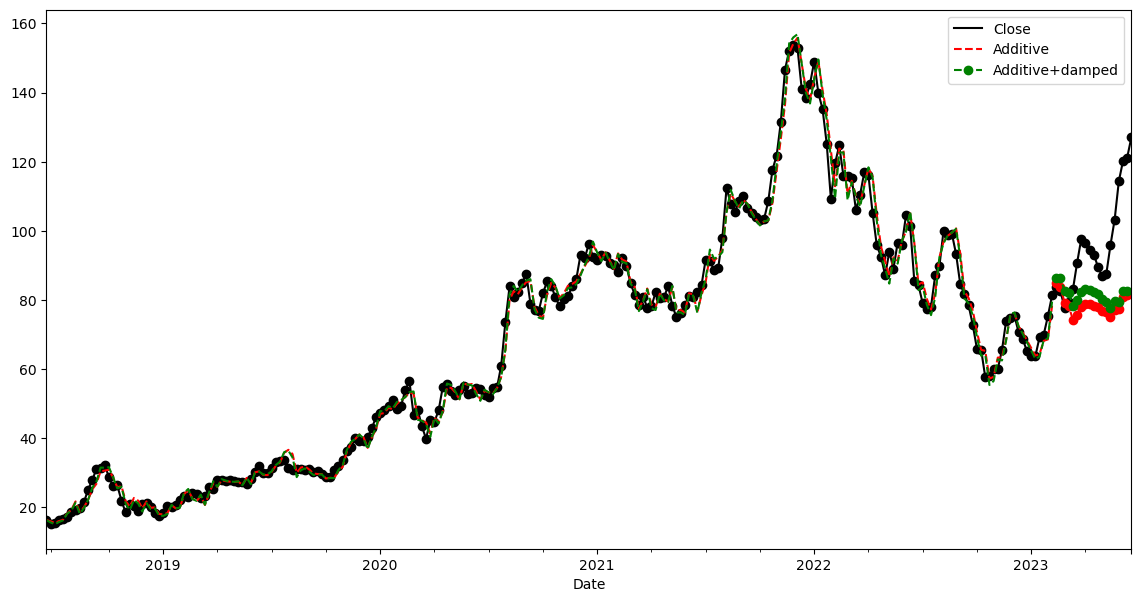

In [326]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
import importlib
importlib.reload(vizFxns)
from vizFxns import *
import numpy as np
vizFxns.holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)
# holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)

In [327]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,52)

C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\npess\.conda\envs\nick_ds\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\npess\.cond

The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(0, 1, 1, 52) - AIC:963.3292112988163


In [329]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date).tz_localize('America/New_York'), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date).tz_localize('America/New_York'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1273      0.237     -0.538      0.590      -0.591       0.336
ma.L1          0.4038      0.217      1.858      0.063      -0.022       0.830
ar.S.L52      -0.7231      0.084     -8.616      0.000      -0.888      -0.559
sigma2        29.2540      3.338      8.764      0.000      22.711      35.797


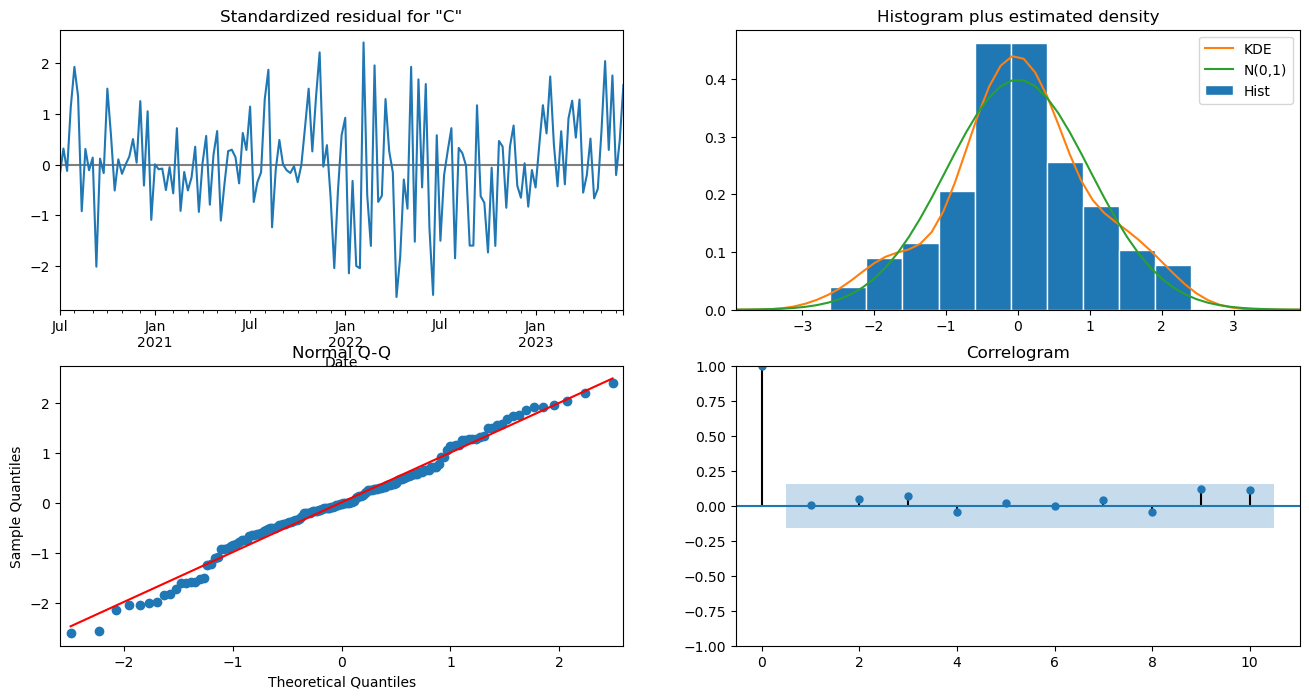

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 5.22


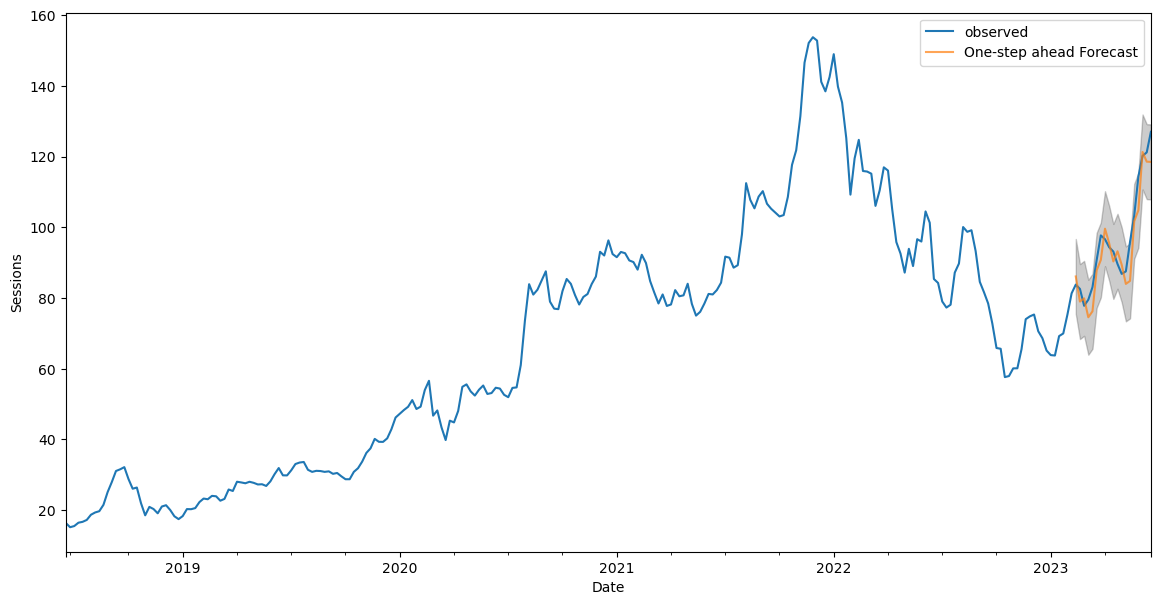

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 30.22


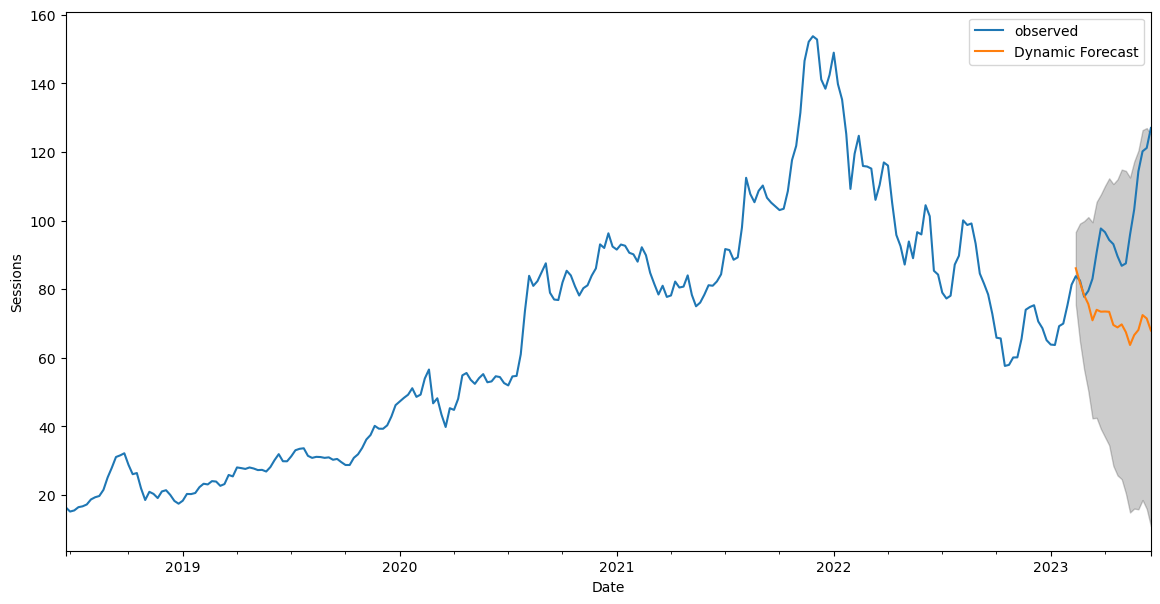

In [330]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,startTestWeekNearestWeek,y_to_val)

In [331]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

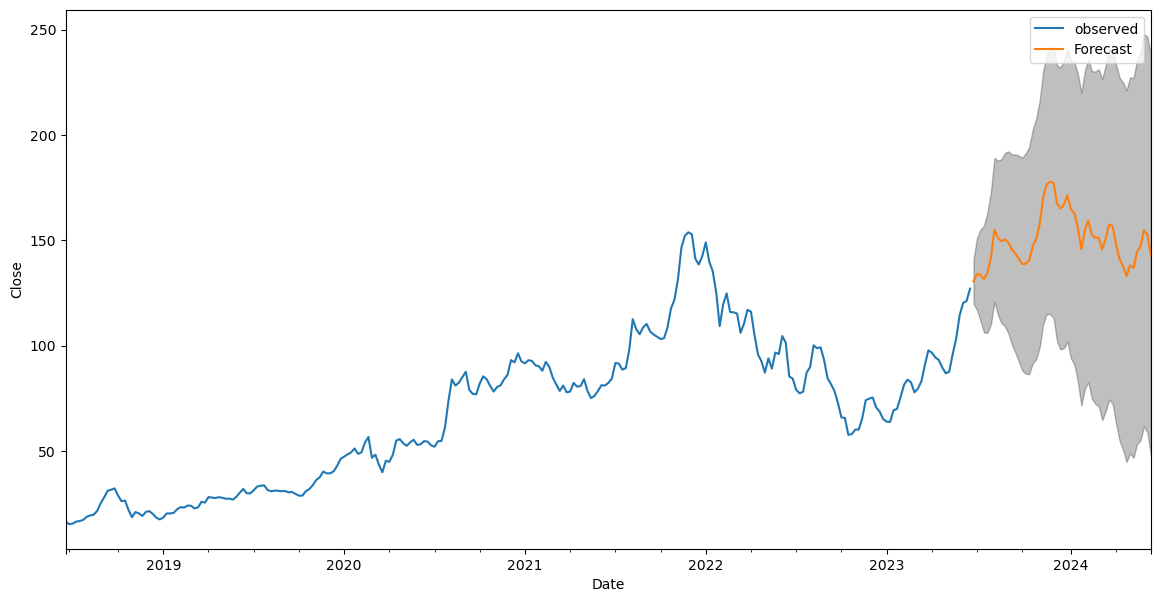

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2023-06-25 00:00:00-04:00,130.45871679,119.85786978,141.05956381
1,2023-07-02 00:00:00-04:00,134.04542787,116.85589075,151.23496498
2,2023-07-09 00:00:00-04:00,133.39370882,111.74604445,155.04137318
3,2023-07-16 00:00:00-04:00,131.57027911,106.21252698,156.92803124
4,2023-07-23 00:00:00-04:00,134.59335902,106.00577444,163.18094361


In [332]:
final_table = forecast(model,52,y)
final_table.head()